## Imports

In [1]:
import multiprocessing
import time

import energyflow as ef
from energyflow.emd import emd
from energyflow.datasets import mod

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import modplot
import utils

## Load MOD Dataset

In [6]:
# set the dataset parameters
ptmin, ptmax, absetamax, quality = 375, 425, 1.9, 2
specs = '{} <= corr_jet_pts <= {} & abs_jet_eta < {} & quality >= {}'.format(ptmin, ptmax, absetamax, quality)

# whether to save the plots
save_plots = False

# whether to use process the files from scratch or use a previous computation
reprocess = True

# set preselected to True if you've previously selected custom datasets
preselected = True

In [3]:
# read in the dataset of simulated "pfcs" jets and the associated generator-level "gens" jets
if not preselected:
    sim = mod.load(specs, dataset='sim', amount=1.0, store_pfcs=True, store_gens=True)
else:
    fp = utils.path('sim', 'h5', 'SIM_Jet300_pT{}-{}GeV'.format(ptmin, ptmax))
    sim = mod.MODDataset(fp, specs)
print('Loaded {} SIM jets'.format(len(sim)))

Loaded 2379525 SIM jets


In [4]:
# function to compute emd between a filtered (sim,gen) pair of jets
def simgenemd(i):
    emds = []
    
    # iterate over particle filters
    for key in keys:
        
        ev0, ev1 = sim.pfcs[i], sim.gens[i]
        filt = filters[key]

        # filter the particles
        ev0 = ev0[utils.filter_particles(ev0, **filt)]
        ev1 = ev1[utils.filter_particles(ev1, **filt)]

        # calculate the EMD and the optimal transport flow
        emdval = pTJ * emd(ev0, ev1, norm=True, R=0.5, gdim=2, empty_policy=-1.)
        emds.append(emdval)
        
    return emds

# compare the filtered SIM to the UNfiltered GEN
def simgenrawemd(i):
    emds = []
    
    # iterate over particle filters
    for key in keys:
        
        ev0, ev1 = sim.pfcs[i], sim.gens[i]
        filt = filters[key]

        # filter the SIM particles
        ev0 = ev0[utils.filter_particles(ev0, **filt)]

        # calculate the EMD and the optimal transport flow
        emdval = pTJ * emd(ev0, ev1, norm=True, R=0.5, gdim=2, empty_policy=-1.)
        emds.append(emdval)
        
    return emds

## SIM-GEN EMDs and Pileup Study

In [5]:
# the total constituent pT will be rescaled to pTJ
pTJ = 400.

# different PFC filtering schemes to try
keys = ['All', 'AllCHS', 'AllPFCpTCut', 'Tracks', 'TracksCHS', 'TracksPFCpTCut']
filters = {
    'All':            {'which': 'all', 'pt_cut': None, 'chs': False},
    'AllCHS':         {'which': 'all', 'pt_cut': None, 'chs': True},
    'AllPFCpTCut':    {'which': 'all', 'pt_cut': 1.0, 'chs': True},
    'Tracks':         {'which': 'charged', 'pt_cut': None, 'chs': False},
    'TracksCHS':      {'which': 'charged', 'pt_cut': None, 'chs': True},
    'TracksPFCpTCut': {'which': 'charged', 'pt_cut': 1.0, 'chs': True},
}

# their plot labels on the legend
labels = {
    'All': 'All PFCs',
    'AllCHS': 'with CHS',
    'AllPFCpTCut': r'with CHS, $p_T^{\mathrm{PFC}}>1$ GeV',
    'Tracks': 'Tracks',
    'TracksCHS': 'with CHS',
    'TracksPFCpTCut': r'with CHS, $p_T^{\mathrm{PFC}}>1$ GeV',
}

# the color of the curve
cmap = matplotlib.cm.get_cmap('nipy_spectral')
colors = {
    'All': cmap(0.9),
    'AllCHS': cmap(0.8),
    'AllPFCpTCut': cmap(0.62),
    'Tracks': cmap(0.41),
    'TracksCHS': cmap(0.35),
    'TracksPFCpTCut': cmap(0.2),
}

In [8]:
# compute the EMD between the sim and gen jets
if reprocess:
    # run the computations in parallel
    start = time.time()
    with multiprocessing.Pool(processes=None) as pool:
        emds_arr = np.asarray(list(pool.map(simgenemd, range(len(sim))))).T

    print('Finished in {:.3f}s'.format(time.time() - start))

Finished in 124.406s


In [9]:
# save/load the EMD to plot
filename = 'SimGenCuts_pT{}-{}GeV_EtaMax{}_Quality{}.npy'.format(ptmin, ptmax, int(10*absetamax), quality)
filepath = utils.path('sim', 'emds', filename)

if reprocess:
    np.save(filepath, emds_arr)
    
emds_arr = np.load(filepath)

## Plotting

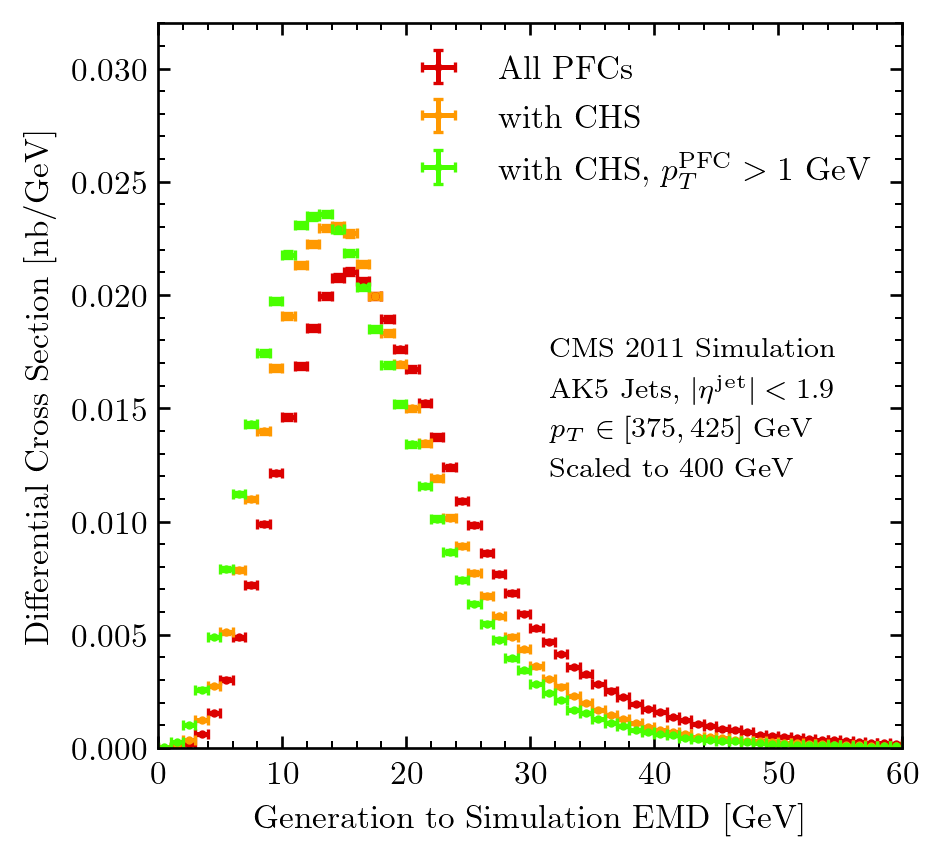

In [10]:
# histogram binning
bins = np.linspace(0, 60, 61)
midbins = (bins[1:] + bins[:-1])/2
step = bins[1] - bins[0]

# get the figure axes
fig, [ax] = modplot.axes(ratio_plot=False, xlim=(min(bins), max(bins)), ylim=(0,0.032), 
                         xlabel=r'Generation to Simulation EMD [GeV]',
                         ylabel=r'Differential Cross Section [nb/GeV]')

# rescale the SIM weights for k-factors and pileup
sim_weights = sim.weights*utils.sim_factors(sim.corr_jet_pts, sim.npvs)
for i,key in enumerate(keys):
    if i >= 3: continue
    emds = emds_arr[i]
    
    # obtain the histogram with statistical uncertainties
    hist, errs, _ = modplot.calc_hist(emds, bins=bins, weights=sim_weights, density=False)
    ax.errorbar(midbins, hist, xerr=step/2, yerr=errs, **modplot.style('errorbar'),
                               color=colors[key], label=labels[key])

# add plot details
ax.legend(loc='upper right', frameon=False)
modplot.stamp(0.525, 0.55, delta_y=0.055, ax=ax,
              line_0='CMS 2011 Simulation',
              line_1='AK5 Jets, $|\eta^{\mathrm{jet}}|<1.9$',
              line_2='$p_T \in [375, 425]$ GeV',
              line_3='Scaled to 400 GeV')

# save plot if specified
if save_plots:
    modplot.save(fig, 'SimGenEMD_CutsAll', tx=46.4, ty=252, out_plots_dir='../plots/SimGenEMD/')

plt.show()

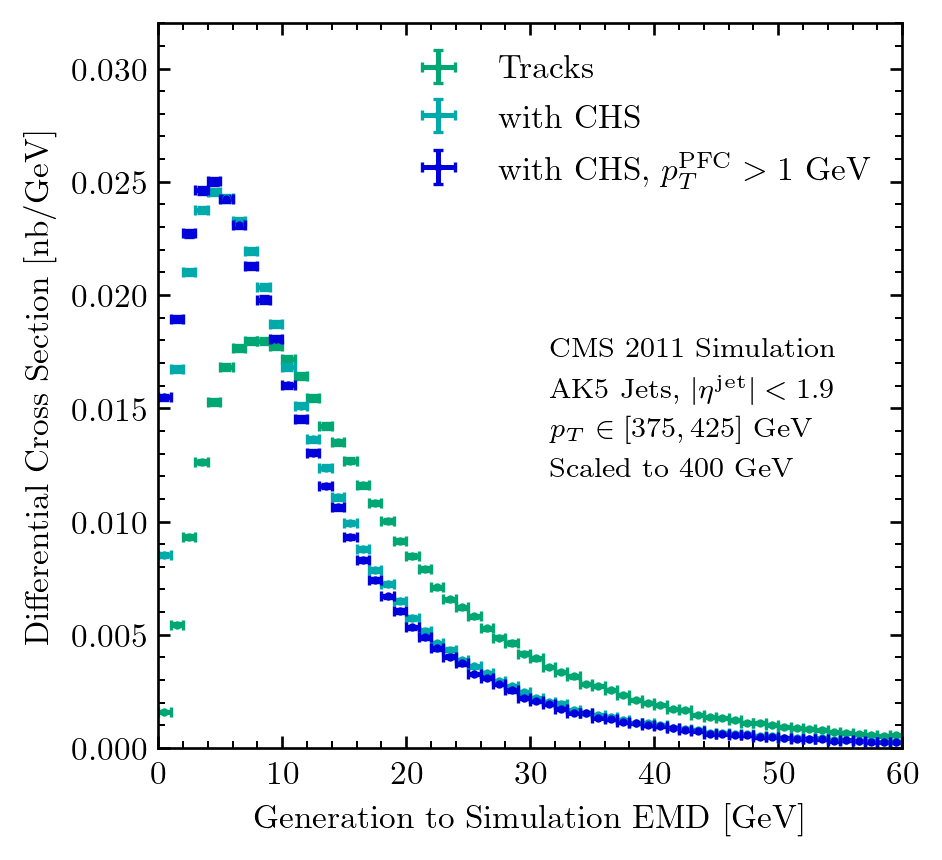

In [11]:
bins = np.linspace(0, 60, 61)
midbins = (bins[1:] + bins[:-1])/2
step = bins[1] - bins[0]

fig, [ax] = modplot.axes(ratio_plot=False, xlim=(min(bins), max(bins)), ylim=(0,0.032), 
                         xlabel=r'Generation to Simulation EMD [GeV]',
                         ylabel=r'Differential Cross Section [nb/GeV]')

sim_weights = sim.weights*utils.sim_factors(sim.corr_jet_pts, sim.npvs)
for i,key in enumerate(keys):
    if i<3: continue
    emds = emds_arr[i]
    hist, errs, _ = modplot.calc_hist(emds, bins=bins, weights=sim_weights, density=False)
    ax.errorbar(midbins, hist, xerr=step/2, yerr=errs, **modplot.style('errorbar'),
                               color=colors[key], label=labels[key])
    
ax.legend(loc='upper right', frameon=False)

# add plot details
modplot.stamp(0.525, 0.55, delta_y=0.055, ax=ax,
              line_0='CMS 2011 Simulation',
              line_1='AK5 Jets, $|\eta^{\mathrm{jet}}|<1.9$',
              line_2='$p_T \in [375, 425]$ GeV',
              line_3='Scaled to 400 GeV')

# save plot
if save_plots:
    modplot.save(fig, 'SimGenEMD_CutsTracks', tx=46.4, ty=252, out_plots_dir='../plots/SimGenEMD/')

plt.show()

In [12]:
# pileup study (continues using EMDs from above)

In [13]:
# specify low medium and high pileup bins boundaries
lowpu, medpu = 5, 10

# colors for All and Track curves, respectively
colorspu = [['red', 'orange', 'olive'], ['green', 'blue', 'purple']]

labelspu = [r'Low Pileup, $N_{\rm{PV}}< ' + str(lowpu) + '$',
            r'Medium Pileup, $N_{\rm{PV}}\in[' + str(lowpu) + ',' + str(medpu) + ']$',
            r'High Pileup, $N_{\rm{PV}}> ' + str(medpu) + '$']

# which specific keys to make the pileup plots for, and how to stamp them
keyspu = ['All', 'AllCHS', 'Tracks', 'TracksCHS']
stampspu = ['All PFCs', 'All PFCs, CHS', 'Tracks', 'Tracks, CHS']

In [14]:
# masks to restrict to jets with different amounts of pileup
lowpu_mask  = (sim.npvs < lowpu)
medpu_mask  = (sim.npvs >= lowpu) & (sim.npvs <= medpu)
highpu_mask = (sim.npvs > medpu)

masks = [lowpu_mask, medpu_mask, highpu_mask]

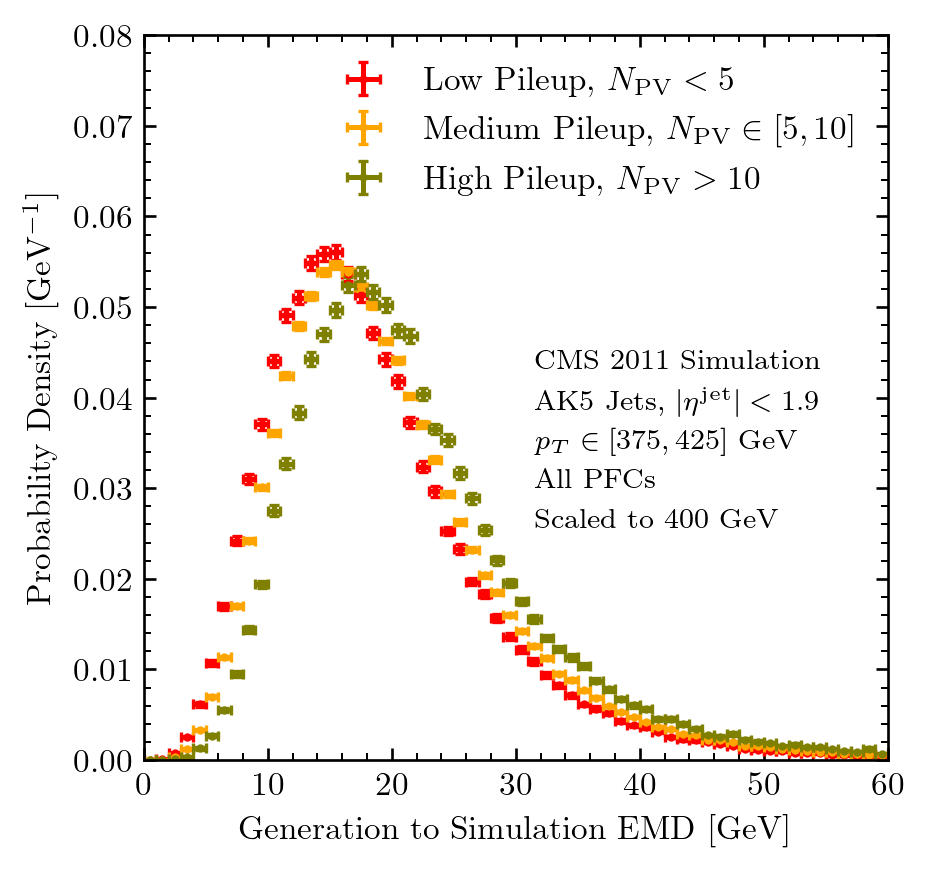

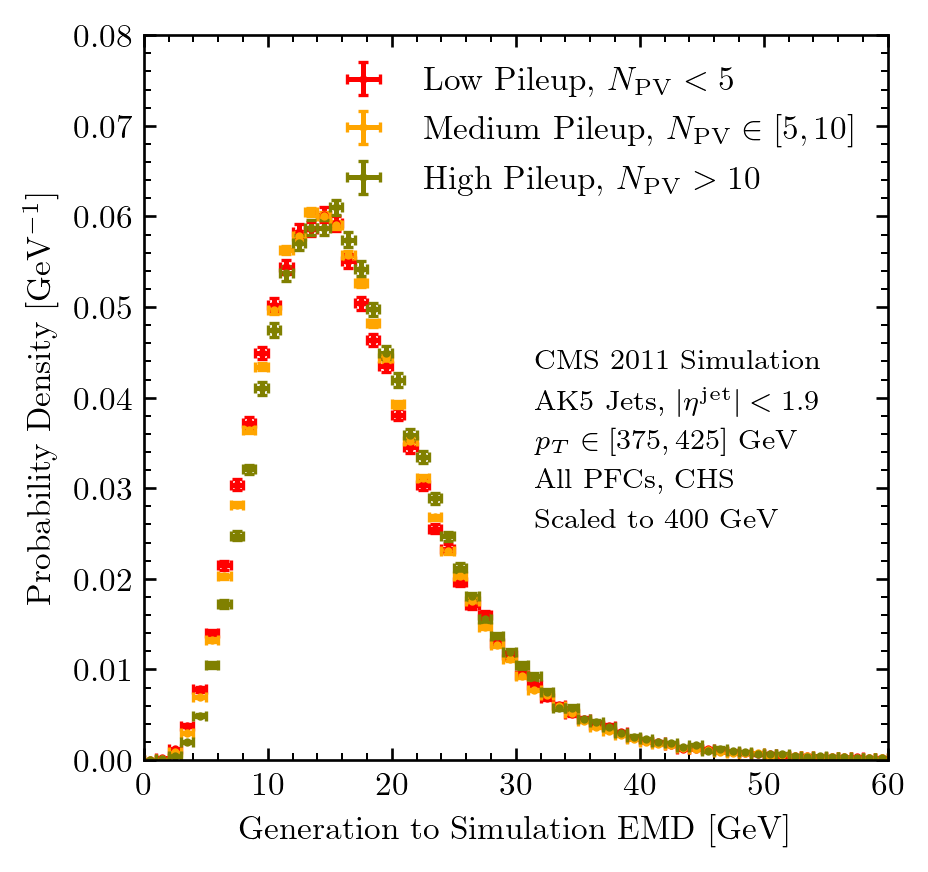

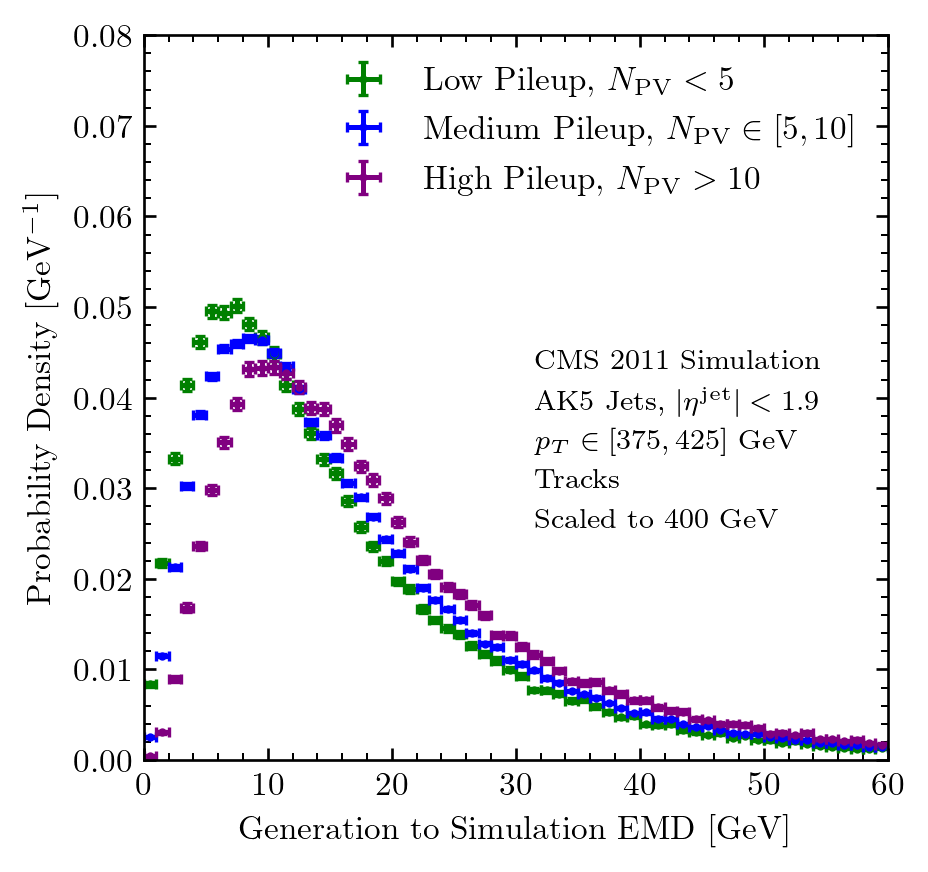

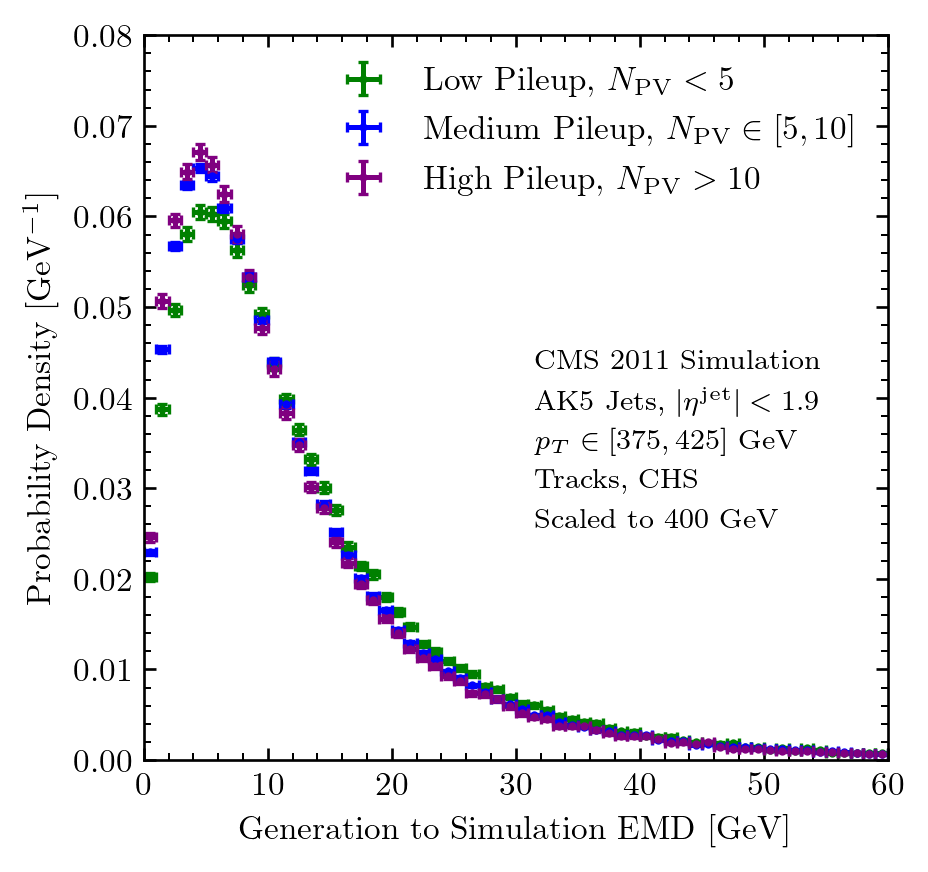

In [15]:
bins = np.linspace(0, 60, 61)
midbins = (bins[1:] + bins[:-1])/2
step = bins[1] - bins[0]

sim_weights = sim.weights*utils.sim_factors(sim.corr_jet_pts, sim.npvs)
for j,keypu in enumerate(keyspu):
    
    # color scheme
    colorlist = colorspu[0] if 'All' in keypu else colorspu[1]
    
    fig, [ax] = modplot.axes(ratio_plot=False, xlim=(min(bins), max(bins)), ylim=(0,0.08), 
                         xlabel=r'Generation to Simulation EMD [GeV]',
                         ylabel=r'Probability Density [GeV$^{-1}$]')
    
    for k,mask in enumerate(masks):
        
        # get the emd vector of that key
        emds = emds_arr[keys.index(keypu)]
        
        # make and plot a histogram
        hist, errs, _ = modplot.calc_hist(emds[mask], bins=bins, weights=sim_weights[mask], density=True)
        ax.errorbar(midbins, hist, xerr=step/2, yerr=errs, **modplot.style('errorbar'),
                                   color=colorlist[k], label=labelspu[k])
        
    # add plot details
    ax.legend(loc='upper right', frameon=False)
    modplot.stamp(0.525, 0.55, delta_y=0.055, ax=ax,
                  line_0='CMS 2011 Simulation',
                  line_1='AK5 Jets, $|\eta^{\mathrm{jet}}|<1.9$',
                  line_2='$p_T \in [375, 425]$ GeV',
                  line_3=stampspu[j],
                  line_4='Scaled to 400 GeV')

    # save plot
    if save_plots or 1:
        modplot.save(fig, 'SimGenEMD_PU'+keypu, tx=42.15, ty=252, out_plots_dir='../plots/SimGenEMD/')

    fig.show()

## SIM-GEN EMDs Varying pT Cut

In [16]:
pTJ = 400.

# different PFC filtering schemes to try
keys = ['AllpT00', 'AllpT05', 'AllpT10', 'AllpT20', 'AllpT50',
        'TrackspT00', 'TrackspT05', 'TrackspT10', 'TrackspT20', 'TrackspT50']
filters = {
    'AllpT00': {'which': 'all', 'pt_cut': None, 'chs': True},
    'AllpT05': {'which': 'all', 'pt_cut': 0.5, 'chs': True},
    'AllpT10': {'which': 'all', 'pt_cut': 1.0, 'chs': True},
    'AllpT20': {'which': 'all', 'pt_cut': 2.0, 'chs': True},
    'AllpT50': {'which': 'all', 'pt_cut': 5.0, 'chs': True},
    'TrackspT00': {'which': 'charged', 'pt_cut': None, 'chs': True},
    'TrackspT05': {'which': 'charged', 'pt_cut': 0.5, 'chs': True},
    'TrackspT10': {'which': 'charged', 'pt_cut': 1.0, 'chs': True},
    'TrackspT20': {'which': 'charged', 'pt_cut': 2.0, 'chs': True},
    'TrackspT50': {'which': 'charged', 'pt_cut': 5.0, 'chs': True}
}

labels = {
    'AllpT00': r'$p_T^{\mathrm{PFC}}>0$ GeV',
    'AllpT05': r'$p_T^{\mathrm{PFC}}>0.5$ GeV',
    'AllpT10': r'$p_T^{\mathrm{PFC}}>1$ GeV',
    'AllpT20': r'$p_T^{\mathrm{PFC}}>2$ GeV',
    'AllpT50': r'$p_T^{\mathrm{PFC}}>5$ GeV',
    'TrackspT00': r'$p_T^{\mathrm{PFC}}>0$ GeV',
    'TrackspT05': r'$p_T^{\mathrm{PFC}}>0.5$ GeV',
    'TrackspT10': r'$p_T^{\mathrm{PFC}}>1$ GeV',
    'TrackspT20': r'$p_T^{\mathrm{PFC}}>2$ GeV',
    'TrackspT50': r'$p_T^{\mathrm{PFC}}>5$ GeV'
}

cmap = matplotlib.cm.get_cmap('nipy_spectral')
colors = {
    'AllpT00': cmap(.8),
    'AllpT05': cmap(.725),
    'AllpT10': cmap(.62),
    'AllpT20': cmap(.52),
    'AllpT50': cmap(.43),
    'TrackspT00': cmap(0.35),
    'TrackspT05': cmap(0.3),
    'TrackspT10': cmap(0.2),
    'TrackspT20': cmap(0.1),
    'TrackspT50': cmap(0.035)
}

In [17]:
if reprocess:
    
    # run the computations in parallel
    start = time.time()
    with multiprocessing.Pool(processes=82) as pool:
        emds_arr = np.asarray(list(pool.map(simgenemd, range(len(sim))))).T
        
    print('Finished in {:.3f}s'.format(time.time() - start))

Finished in 179.017s


In [18]:
filename = 'SimGenPFCpTCuts_pT{}-{}GeV_EtaMax{}_Quality{}.npy'.format(ptmin, ptmax, int(10*absetamax), quality)
filepath = utils.path('sim', 'emds', filename)

if reprocess:
    np.save(filepath, emds_arr)

emds_arr = np.load(filepath)

## Plotting

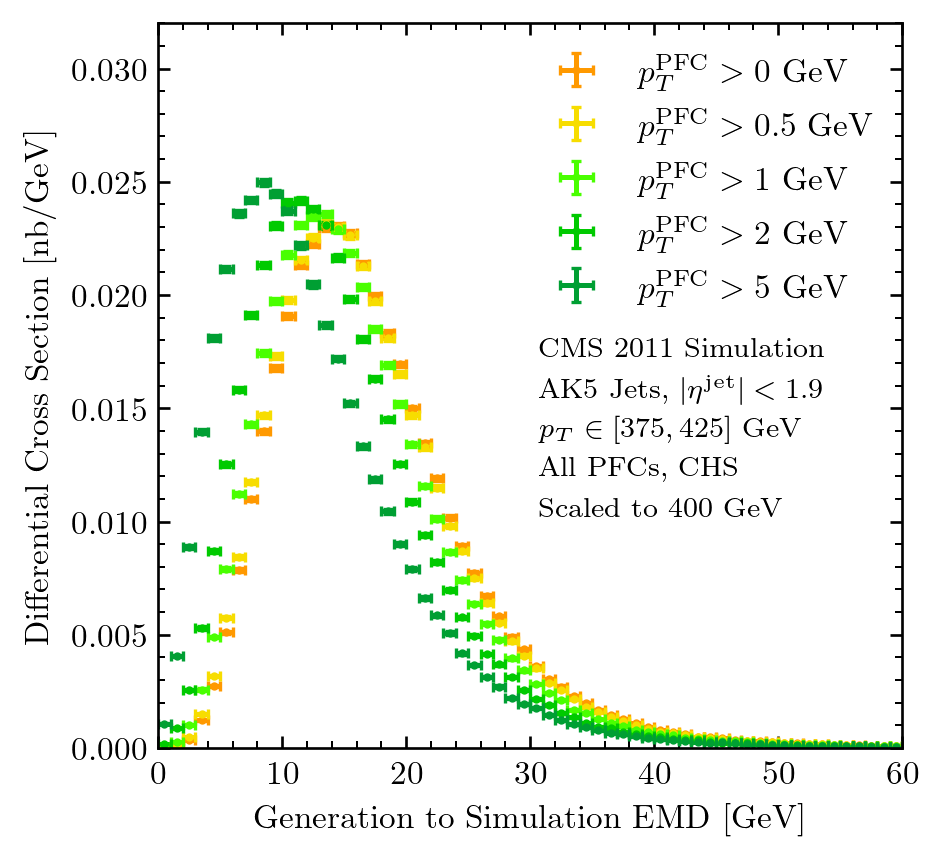

In [19]:
bins = np.linspace(0, 60, 61)
midbins = (bins[1:] + bins[:-1])/2
step = bins[1] - bins[0]

fig, [ax] = modplot.axes(ratio_plot=False, xlim=(min(bins), max(bins)), ylim=(0,0.032), 
                         xlabel=r'Generation to Simulation EMD [GeV]',
                         ylabel=r'Differential Cross Section [nb/GeV]')

sim_weights = sim.weights*utils.sim_factors(sim.corr_jet_pts, sim.npvs)
for i,key in enumerate(keys):
    if i>=5: continue
    emds = emds_arr[i]
    hist, errs, _ = modplot.calc_hist(emds, bins=bins, weights=sim_weights, density=False)
    ax.errorbar(midbins, hist, xerr=step/2, yerr=errs, **modplot.style('errorbar'),
                               color=colors[key], label=labels[key])
    
ax.legend(loc='upper right', frameon=False)

# add plot details
modplot.stamp(0.51, 0.55, delta_y=0.055, ax=ax,
              line_0='CMS 2011 Simulation',
              line_1='AK5 Jets, $|\eta^{\mathrm{jet}}|<1.9$',
              line_2='$p_T \in [375, 425]$ GeV',
              line_3='All PFCs, CHS',
              line_4='Scaled to 400 GeV')

# save plot
if save_plots:
    modplot.save(fig, 'SimGenEMD_PFCpTCutsAll', tx=46.4, ty=252, out_plots_dir='../plots/SimGenEMD/')

plt.show()

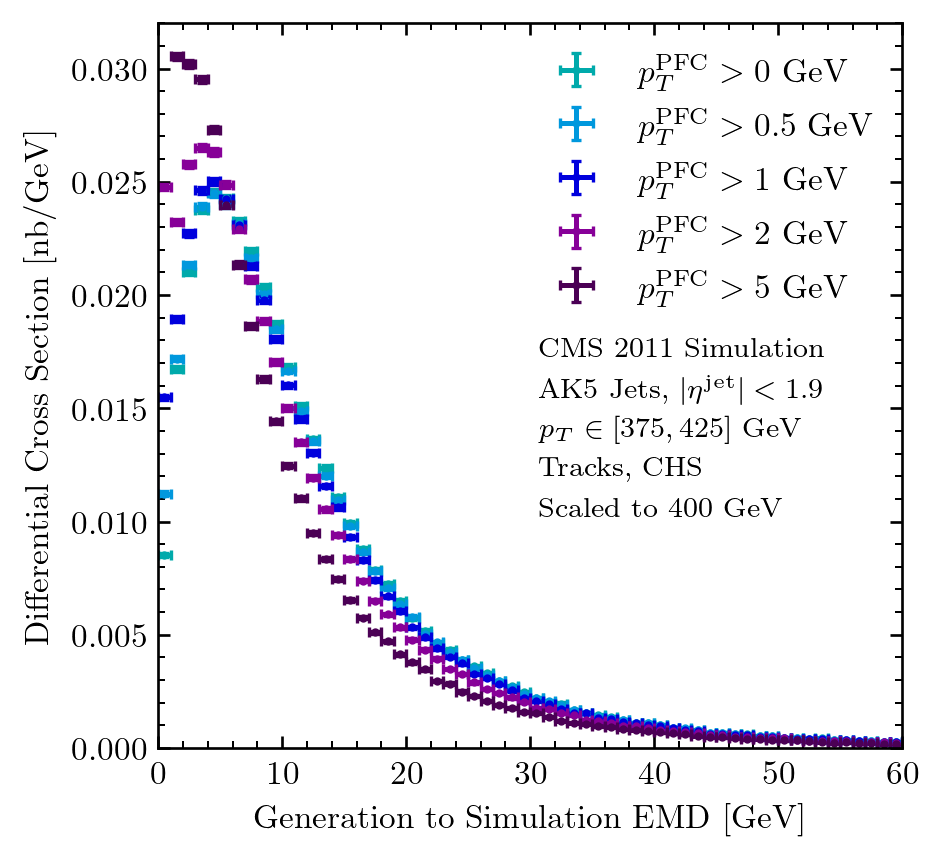

In [20]:
bins = np.linspace(0, 60, 61)
midbins = (bins[1:] + bins[:-1])/2
step = bins[1] - bins[0]

fig, [ax] = modplot.axes(ratio_plot=False, xlim=(min(bins), max(bins)), ylim=(0,0.032), 
                         xlabel=r'Generation to Simulation EMD [GeV]',
                         ylabel=r'Differential Cross Section [nb/GeV]')

sim_weights = sim.weights*utils.sim_factors(sim.corr_jet_pts, sim.npvs)
for i,key in enumerate(keys):
    if i<5: continue
    emds = emds_arr[i]
    hist, errs, _ = modplot.calc_hist(emds, bins=bins, weights=sim_weights, density=False)
    ax.errorbar(midbins, hist, xerr=step/2, yerr=errs, **modplot.style('errorbar'),
                               color=colors[key], label=labels[key])
    
ax.legend(loc='upper right', frameon=False)

# add plot details
modplot.stamp(0.51, 0.55, delta_y=0.055, ax=ax,
              line_0='CMS 2011 Simulation',
              line_1='AK5 Jets, $|\eta^{\mathrm{jet}}|<1.9$',
              line_2='$p_T \in [375, 425]$ GeV',
              line_3='Tracks, CHS',
              line_4='Scaled to 400 GeV')

# save plot
if save_plots:
    modplot.save(fig, 'SimGenEMD_PFCpTCutsTrack', tx=46.4, ty=252, out_plots_dir='../plots/SimGenEMD/')

plt.show()

In [21]:
if reprocess:
    
    # run the computations in parallel
    start = time.time()
    with multiprocessing.Pool(processes=82) as pool:
        emds_arr = np.asarray(list(pool.map(simgenrawemd, range(len(sim))))).T
        
    print('Finished in {:.3f}s'.format(time.time() - start))

Finished in 193.575s


In [22]:
filename = 'SimGenRawPFCpTCuts_pT{}-{}GeV_EtaMax{}_Quality{}.npy'.format(ptmin, ptmax, int(10*absetamax), quality)
filepath = utils.path('sim', 'emds', filename)

if reprocess:
    np.save(filepath, emds_arr)

emds_arr = np.load(filepath)

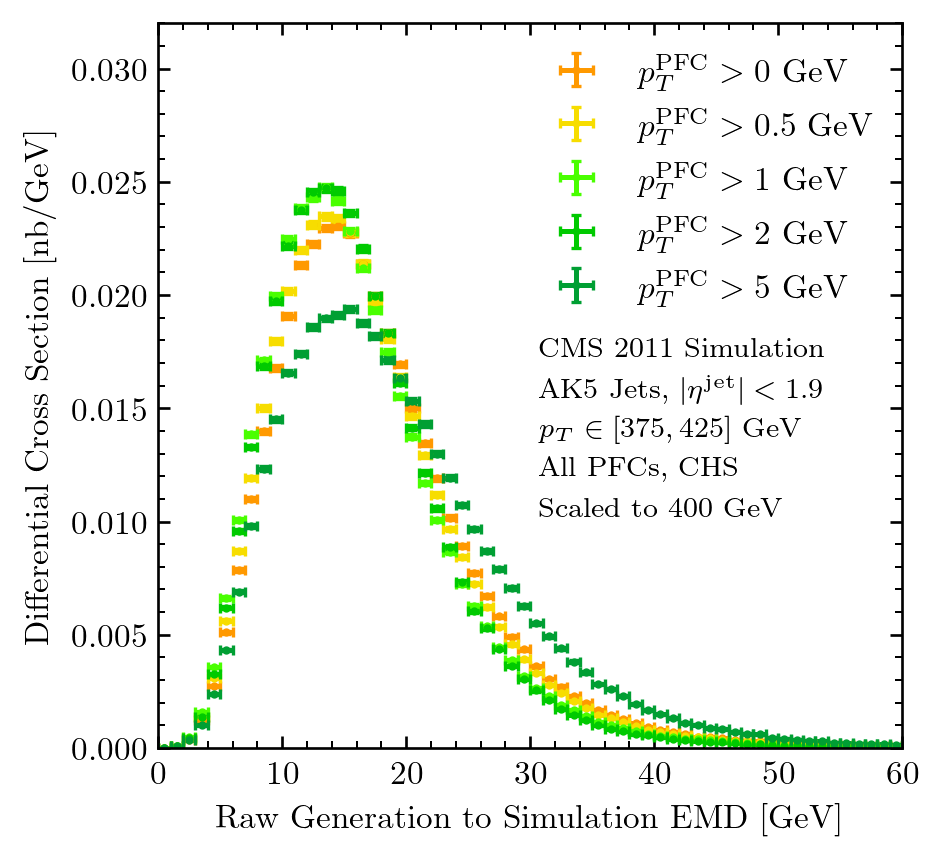

In [23]:
bins = np.linspace(0, 60, 61)
midbins = (bins[1:] + bins[:-1])/2
step = bins[1] - bins[0]

fig, [ax] = modplot.axes(ratio_plot=False, xlim=(min(bins), max(bins)), ylim=(0,0.032), 
                         xlabel=r'Raw Generation to Simulation EMD [GeV]',
                         ylabel=r'Differential Cross Section [nb/GeV]')

sim_weights = sim.weights*utils.sim_factors(sim.corr_jet_pts, sim.npvs)
for i,key in enumerate(keys):
    if i>=5: continue
    emds = emds_arr[i]
    hist, errs, _ = modplot.calc_hist(emds, bins=bins, weights=sim_weights, density=False)
    ax.errorbar(midbins, hist, xerr=step/2, yerr=errs, **modplot.style('errorbar'),
                               color=colors[key], label=labels[key])
    
ax.legend(loc='upper right', frameon=False)

# add plot details
modplot.stamp(0.51, 0.55, delta_y=0.055, ax=ax,
              line_0='CMS 2011 Simulation',
              line_1='AK5 Jets, $|\eta^{\mathrm{jet}}|<1.9$',
              line_2='$p_T \in [375, 425]$ GeV',
              line_3='All PFCs, CHS',
              line_4='Scaled to 400 GeV')

# save plot
if save_plots:
    modplot.save(fig, 'SimGenRawEMD_PFCpTCutsAll', tx=46.4, ty=252, out_plots_dir='../plots/SimGenEMD/')

plt.show()

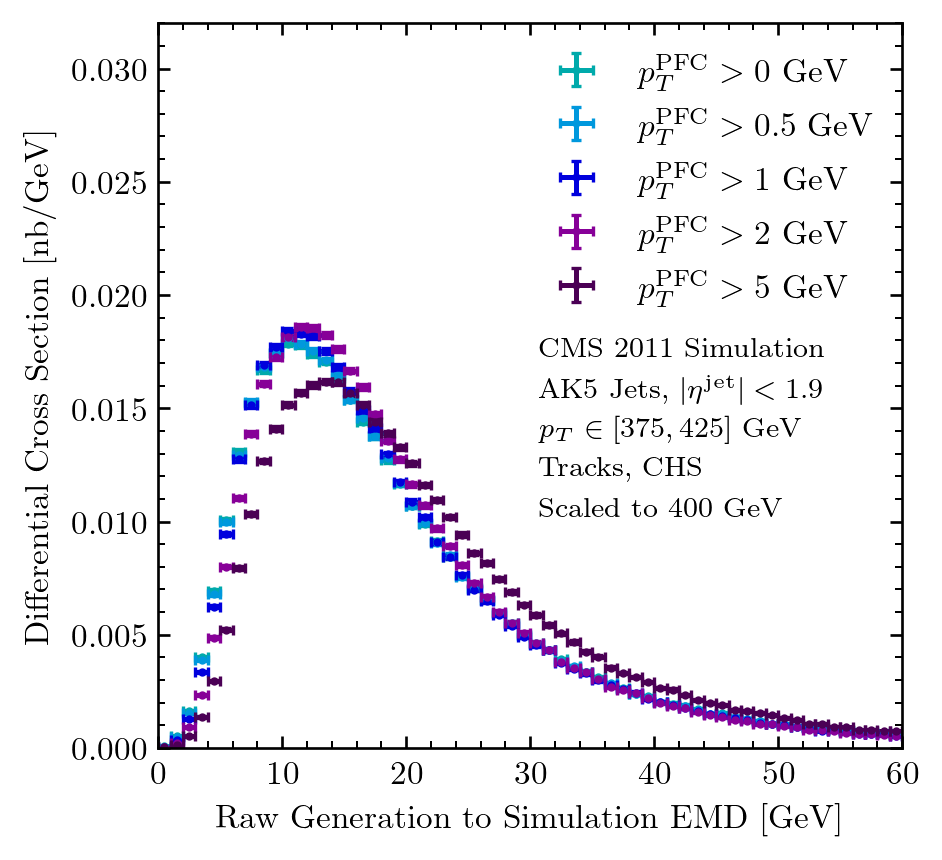

In [24]:
bins = np.linspace(0, 60, 61)
midbins = (bins[1:] + bins[:-1])/2
step = bins[1] - bins[0]

fig, [ax] = modplot.axes(ratio_plot=False, xlim=(min(bins), max(bins)), ylim=(0,0.032), 
                         xlabel=r'Raw Generation to Simulation EMD [GeV]',
                         ylabel=r'Differential Cross Section [nb/GeV]')

sim_weights = sim.weights*utils.sim_factors(sim.corr_jet_pts, sim.npvs)
for i,key in enumerate(keys):
    if i<5: continue
    emds = emds_arr[i]
    hist, errs, _ = modplot.calc_hist(emds, bins=bins, weights=sim_weights, density=False)
    ax.errorbar(midbins, hist, xerr=step/2, yerr=errs, **modplot.style('errorbar'),
                               color=colors[key], label=labels[key])
    
ax.legend(loc='upper right', frameon=False)

# add plot details
modplot.stamp(0.51, 0.55, delta_y=0.055, ax=ax,
              line_0='CMS 2011 Simulation',
              line_1='AK5 Jets, $|\eta^{\mathrm{jet}}|<1.9$',
              line_2='$p_T \in [375, 425]$ GeV',
              line_3='Tracks, CHS',
              line_4='Scaled to 400 GeV')

# save plot
if save_plots:
    modplot.save(fig, 'SimGenRawEMD_PFCpTCutsTrack', tx=46.4, ty=252, out_plots_dir='../plots/SimGenEMD/')

plt.show()

## Event Displays

In [25]:
# different PFC filtering schemes to try
keys = ['All', 'CHS', 'PFCpTCut', 'Tracks', 'TracksPFCpTCut']
filters = {
    'All': {'which': 'all', 'pt_cut': None, 'chs': False},
    'CHS': {'which': 'all', 'pt_cut': None, 'chs': True},
    'PFCpTCut': {'which': 'all', 'pt_cut': 1.0, 'chs': True},
    'Tracks': {'which': 'charged', 'pt_cut': None, 'chs': True},
    'TracksPFCpTCut': {'which': 'charged', 'pt_cut': 1.0, 'chs': True},
}

stamplines = [('','All PFCs'), (', CHS','All PFCs'), (', CHS',r'$p_T^{\mathrm{PFC}}>1$ GeV'),
              (', CHS','Tracks'), (', CHS',r'Tracks, $p_T^{\mathrm{PFC}}>1$ GeV')]

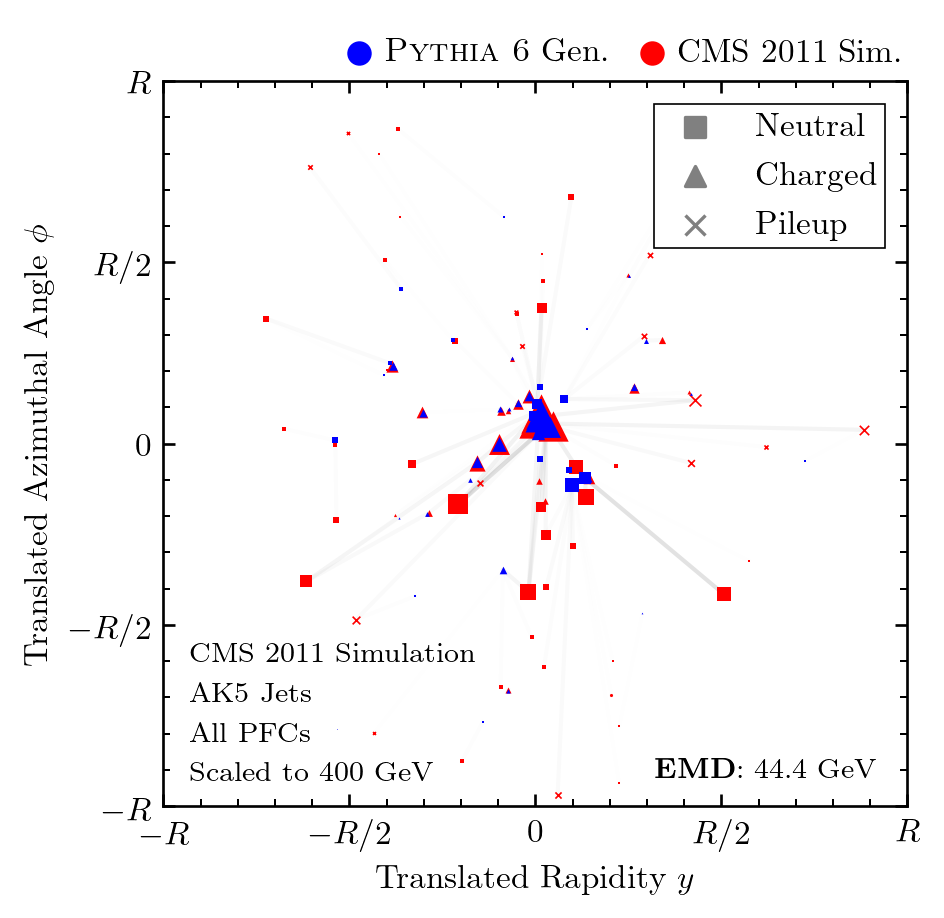

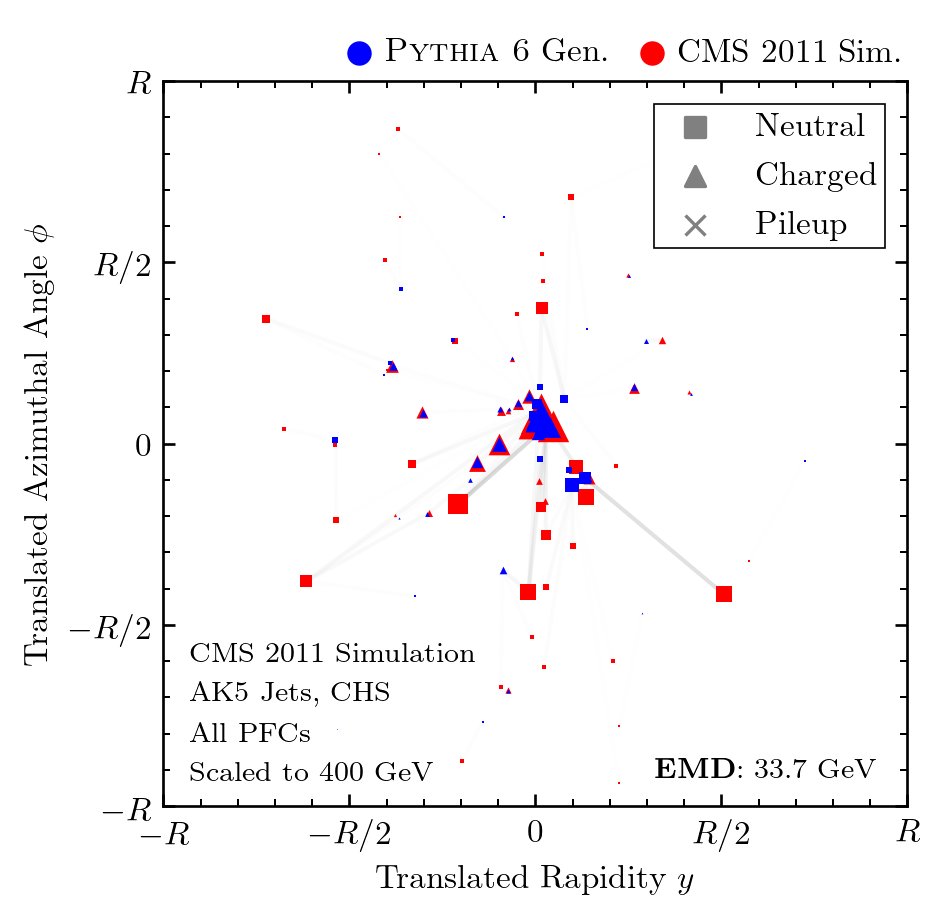

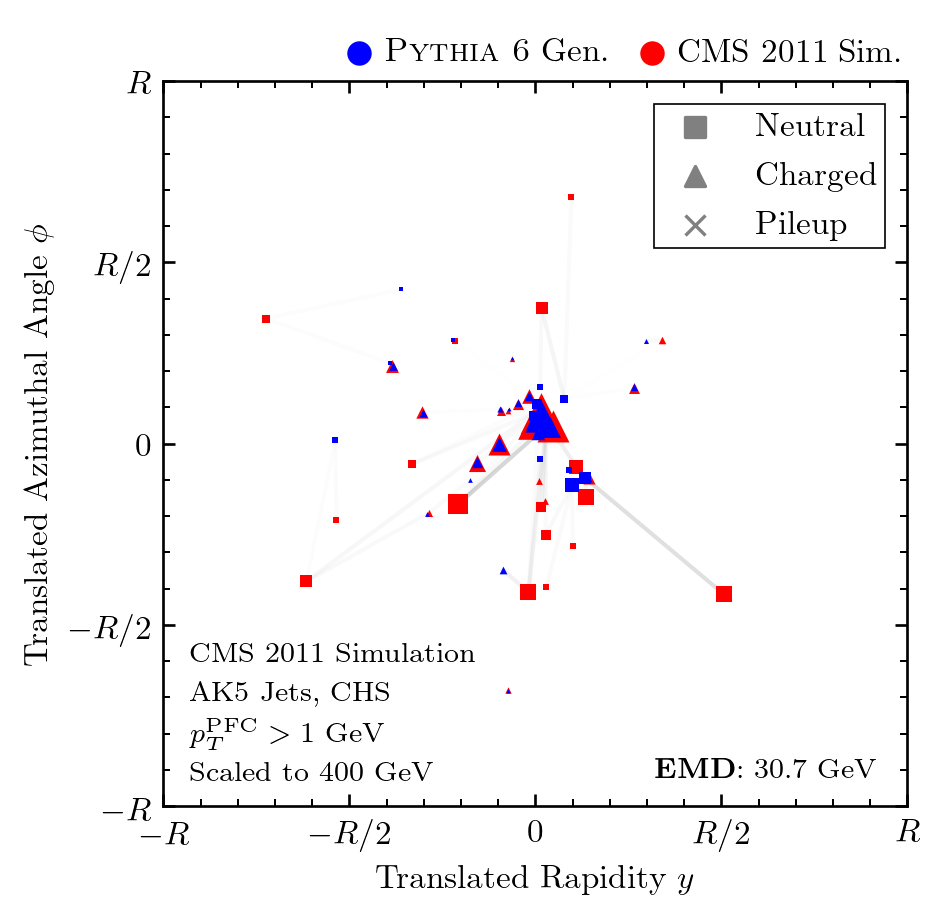

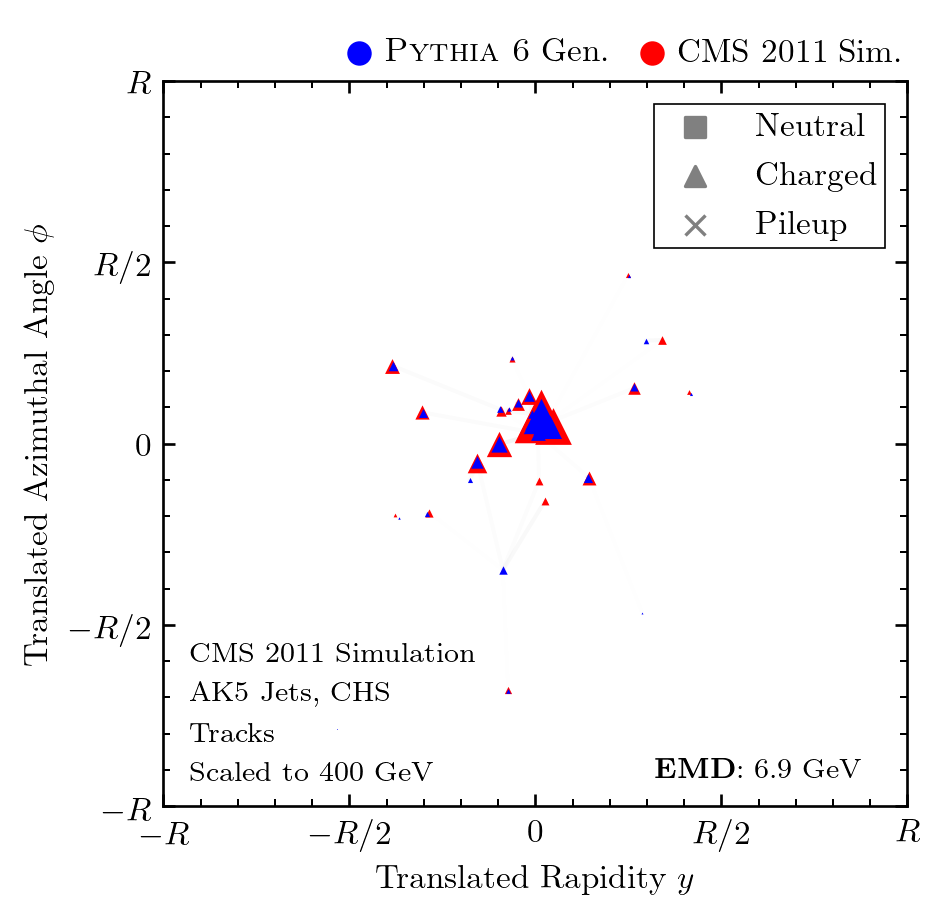

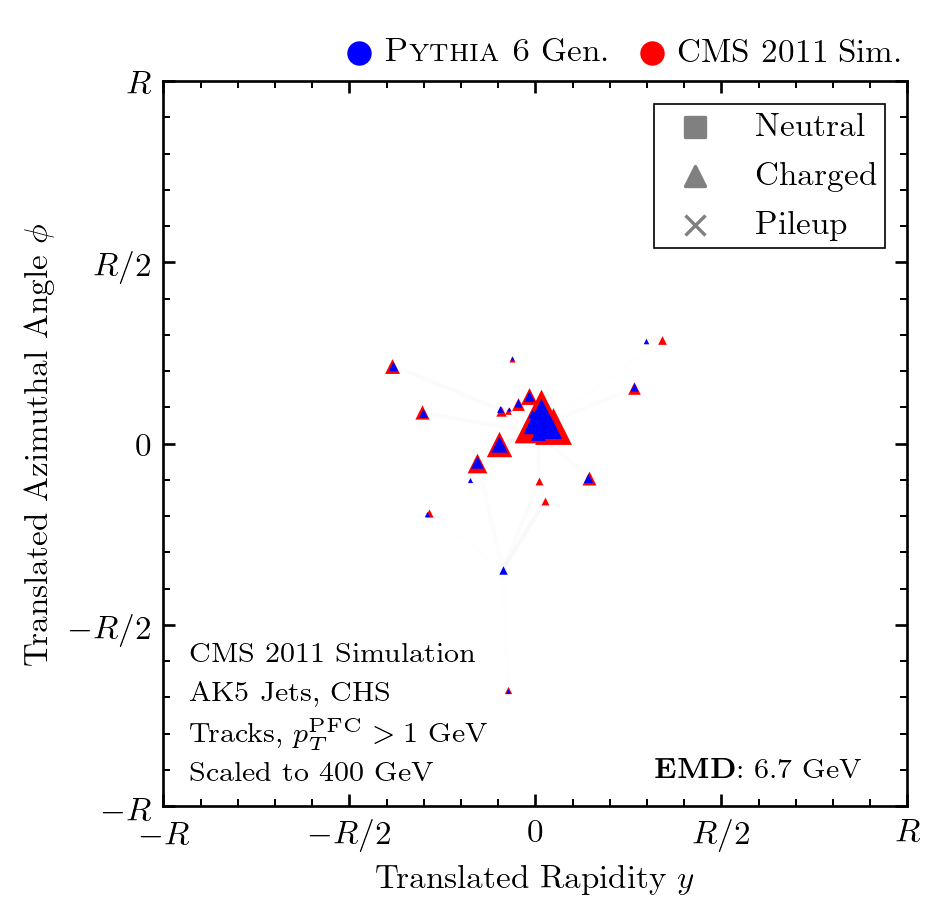

In [26]:
for k,(stampline,key) in enumerate(zip(stamplines,keys)):

    # choose interesting event
    #i = 2004710 #i = 2145848 #i = 1506776 #i = 173455
    i = 1306306
    evn = sim.evns[i]

    # get the list of particles in the two events
    ev0, ev1 = np.copy(sim.gens[i]), np.copy(sim.pfcs[i])

    # filter the particles
    ev0 = ev0[utils.filter_particles(ev0, **filters[key])]
    ev1 = ev1[utils.filter_particles(ev1, **filters[key])]

    # center SIM and GEN consistently (i.e. in the same way)
    if k==0:
        yJ = np.average(ev1[:,1], weights=ev1[:,0])
        phiJ = np.average(ev1[:,2], weights=ev1[:,0])

    # scale the jets to 400 GeV
    ev0[:,0] *= 400/np.sum(ev0[:,0])
    ev1[:,0] *= 400/np.sum(ev1[:,0])

    # calculate the EMD and the optimal transport flow
    R = 0.5
    emdval, G = emd(ev0, ev1, R=R, gdim=2, norm=True, return_flow=True)
    emdval *= 400
    G *= 400

    fig, [ax] = modplot.axes(ratio_plot=False, xlim=(-R, R), ylim=(-R, R), 
                             xlabel=r'Translated Rapidity $y$', ylabel=r'Translated Azimuthal Angle $\phi$',
                             xtick_step=0.25, ytick_step=0.25,
                             xticks=[r'$-R$', r'$-R/2$', r'$0$', r'$R/2$', r'$R$'],
                             yticks=[r'$-R$', r'$-R/2$', r'$0$', r'$R/2$', r'$R$'])

    # plot the two events
    zfs = [1, 2]
    markers = ['^','s']
    colors = ['blue', 'red']
    labels = [r'\textsc{Pythia 6} Gen.', 'CMS 2011 Sim.']
    for i,ev in enumerate([ev0, ev1]):
        pts, ys, phis, pids, verts = ev[:,0], ev[:,1] - yJ, ev[:,2] - phiJ, ev[:,4], ev[:,5]
        for pt,y,phi,pid,vert in zip(pts, ys, phis, pids, verts):
            marker = 'x' if vert > 0 else ('^' if ef.ischrgd(pid) else 's')
            ax.scatter(y, phi, marker=marker, zorder=10-i, s=zfs[i]*pt, color=colors[i], 
                              lw=(0 if marker != 'x' else .5))

    # plot the flow
    mx = G.max()
    xs, xt = ev0[:,1:3] - [yJ, phiJ], ev1[:,1:3] - [yJ, phiJ]
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            if G[i, j] > 0:
                ax.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                             alpha=G[i,j]/mx, lw=1.25, color='black')
                
    # legend 1
    ax.scatter([], [], s=40, color=colors[0], label=labels[0])
    ax.scatter([], [], s=40, color=colors[1], label=labels[1])
    lgnd = ax.legend(loc=(0.2, 1.0), frameon=False, ncol=2, handletextpad=-0.25, columnspacing=0.25)
    
    # legend 2
    p1 = ax.scatter([], [], marker='s', color='gray')
    p2 = ax.scatter([], [], marker='^', color='gray')
    p3 = ax.scatter([], [], marker='x', color='gray', lw=1)
    leg = ax.legend(handles=[p1, p2, p3], labels=['Neutral', 'Charged', 'Pileup'], loc='upper right',
                    frameon=True, edgecolor='black', facecolor='white', fancybox=False, framealpha=1.0)
    leg.set_zorder(20)
    leg.get_frame().set_linewidth(0.5)
    leg.get_frame().set_boxstyle('square', pad=-0.175)
    
    ax.add_artist(lgnd)

    # add plot details
    ax.text(0.66, 0.04, r'{\bf EMD}'+': {:.1f} GeV'.format(emdval), 
                 fontsize=8.5, transform=ax.transAxes)
    modplot.stamp(0.035, 0.21, delta_y=0.055, line_0='CMS 2011 Simulation', ax=ax,
                  line_1=r'AK5 Jets'+stampline[0], line_2=stampline[1], line_3='Scaled to 400 GeV')

    # save plot
    if save_plots:
        modplot.save(fig, 'SimGen_Jet_Display_{}_{}'.format(evn, key), 
                     tx=48, ty=252, out_plots_dir='../plots/SimGenEMD/')

    fig.show()